# BrisT1D Blood Glucose Prediction Competition
Source: [BrisT1D Data](https://www.kaggle.com/competitions/brist1d/data)

This notebook compares different models for predicting blood glucose levels +1 hour ahead using historical data from participants. The goal is to forecast blood glucose levels based on the previous six hours of glucose measurements.

## Input Data
The dataset contains only **blood glucose time series** for each participant. Due to resource limitations, only this feature is used, and additional data sources (such as heart rate or insulin levels) are excluded. The focus of this notebook is to compare model performance using this sole input.

## Models
- **LSTM (Long Short-Term Memory)**: Well-suited for time series forecasting, LSTMs are capable of capturing temporal dependencies in data. They are ideal for predicting future blood glucose levels based on past readings.
  
- **LSTM + CNN**: This hybrid model combines the strengths of LSTMs for sequence learning and CNNs for feature extraction. The CNN component helps in identifying local patterns within the time series before feeding them into the LSTM layers.

- **Transformer**: The Transformer model uses self-attention mechanisms to capture long-range dependencies within the data. While Transformers excel in tasks requiring global context, they might not always outperform simpler models like LSTMs when the sequence length is short (as in this dataset).

This notebook aims to evaluate the performance of these models on the blood glucose prediction task, with the goal of identifying the best-performing architecture for this specific problem.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# get data
data_path = Path("~/Data/brist1d/")
train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)
test = pd.read_csv(data_path/ "test.csv", header = 0, index_col = 0)
submission = pd.read_csv(data_path/ "sample_submission.csv")

# sample_sub.head()
# train.head()
train.shape, test.shape, submission.shape

/var/folders/bs/gvm42h356mz5vjf9v118br000000gn/T/ipykernel_43804/4102449935.py:3: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)


((177024, 507), (3644, 506), (3644, 2))

In [3]:
# print the index of the unique features
feature_group_name = train.columns.str.extract(r"(^[a-zA-Z]+)")[0]  # get initial part of name
grouped_cols = train.columns.groupby(feature_group_name)
unique_initial_parts = {key: list(values) for key, values in grouped_cols.items()}  # get index values for each unique feature group
cols_indices = {key: [train.columns.get_loc(col) for col in values] for key, values in unique_initial_parts.items()}  # get column indices
    
# print indices
for key, indices in cols_indices.items():
    print(f"{key}: {indices}")
    
# bg: blood glucose
# cals: total calories burnt in the last 5 mins
# carbs: total carbohydrate value consumed in grammes in the last 5 mins
# hr: mean heart rate per min
# steps: total steps walked in the last 5 min
# time: time of the day HH:MM:SS

activity: [434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505]
bg: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 506]
cals: [362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 42

In [4]:
# Only select the blood glucose values
X = train.iloc[:,2:74]  # start with only blood glucose
y = train['bg+1:00'].values.reshape(-1, 1)
Z = test.iloc[:,2:74]

X.shape, y.shape, Z.shape

((177024, 72), (177024, 1), (3644, 72))

## Handling Missing Values in Blood Glucose Data

In this section, we handle missing values (NaNs) in the blood glucose time series by applying **linear interpolation**. Linear interpolation estimates the missing values based on the values before and after the missing data points.

0


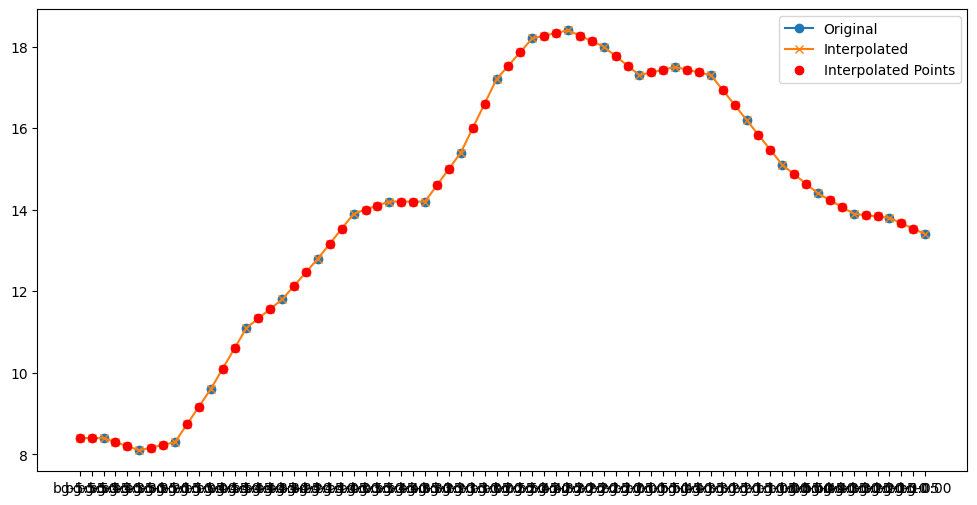

In [5]:
# Interpolate missing values using linear interpolation
X_interpolated = X.interpolate(method='linear', axis=1, limit_direction='both')

# Check the result
print(X_interpolated.isna().sum().sum())  # Should be 0 if all NaNs are imputed

# Plot original and interpolated values for a specific patient
patient = "p01_4"
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(X.loc[patient], "o-", label="Original")
ax.plot(X_interpolated.loc[patient], "x-", label="Interpolated")

# Highlight interpolated points
interpolated_points = X.isna() & X_interpolated.notna()
interpolated_indices = interpolated_points.loc[patient][interpolated_points.loc[patient]].index
ax.plot(interpolated_indices, X_interpolated.loc[patient, interpolated_indices], "ro", label="Interpolated Points")

ax.legend()
plt.show()

In [6]:
# Set device to use GPU usage with PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare Data

In this section, the data is preprocessed and formatted so it can be used for training with PyTorch models. The two models that will be tested, **LSTM** and **LSTM + CNN**, expect the input data to be in the format `(batch_size, sequence_length, input_size)`. Therefore, the data for these models does not need to be adjusted further.

However, **Transformers** require the data to be reshaped in a specific way (see Transformers section below for more details).

### Data Dimensions

- `reshaped_data` has shape `(samples, 72, feature_dim)`, where:
  - `samples` represents the number of data points (or patients).
  - `72` corresponds to the time steps in the sequence (i.e., the length of the time series).
  - `feature_dim` is the number of features per time step (in this case, `feature_dim = 1` for a single feature, blood glucose level).
  
For example, if there are 1000 samples and each time series has 72 time steps and 1 feature (blood glucose level), the shape of the data will be `(1000, 72, 1)`.

This format is directly compatible with LSTM and LSTM + CNN models, as they expect sequences where:
- The **first dimension** is the batch size.
- The **second dimension** is the sequence length (number of time steps).
- The **third dimension** is the number of features per time step.

For **Transformers**, however, a slight adjustment to the data format is necessary to align with the model’s requirements (see the section on Transformers for the reshaping details). The reshaping of the data is taken care of in the model itself. The DataLoader itself will be used and not amended. 


In [7]:
# Uses interpolated data
X2 = X_interpolated.values

# Reshape for LSTM
samples, time_steps = X.shape[0], 72
reshaped_data = X2.reshape(samples, time_steps, -1)

# Standardize
scaler = StandardScaler()
reshaped_data = scaler.fit_transform(reshaped_data.reshape(-1, reshaped_data.shape[-1])).reshape(reshaped_data.shape)
print(f"Reshaped data shape: {reshaped_data.shape}")

# Split data
X3_train, X3_test, y3_train, y3_test = train_test_split(reshaped_data, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X3_train = torch.tensor(X3_train, dtype=torch.float32)
X3_test = torch.tensor(X3_test, dtype=torch.float32)
y3_train = torch.tensor(y3_train, dtype=torch.float32).view(-1, 1)
y3_test = torch.tensor(y3_test, dtype=torch.float32).view(-1, 1)
print(f"X3_train shape: {X3_train.shape}, y3_train shape: {y3_train.shape}, X3_test shape: {X3_test.shape}, y3_test shape: {y3_test.shape}")

# Dataloader
batch_size = 32         # Number of samples per batch
train_loader = DataLoader(TensorDataset(X3_train, y3_train), batch_size=batch_size, shuffle=True)
print(f"train_loader length: {len(train_loader)}")
val_loader = DataLoader(TensorDataset(X3_test, y3_test), batch_size=batch_size, shuffle=False)
print(f"val_loader length: {len(val_loader)}")

Reshaped data shape: (177024, 72, 1)
X3_train shape: torch.Size([141619, 72, 1]), y3_train shape: torch.Size([141619, 1]), X3_test shape: torch.Size([35405, 72, 1]), y3_test shape: torch.Size([35405, 1])
train_loader length: 4426
val_loader length: 1107


## LSTM with ReLU and Dropout

The LSTM model used for blood glucose prediction is designed with two key components: **ReLU activation** and **Dropout**. These choices are made to improve the model’s performance by preventing overfitting and enhancing its ability to learn from the data.

### Why ReLU?

- **ReLU Activation**: The LSTM's default activation function for the gates is **tanh**, which can sometimes lead to vanishing gradient problems, especially in deeper networks. By introducing **ReLU (Rectified Linear Unit)**, we allow for more effective gradient propagation through the network, especially in the context of sequential data. ReLU is computationally efficient and helps in capturing the non-linear relationships in time-series data, which is essential for tasks like blood glucose prediction.
- **Effect on Model**: By using **ReLU**, the model is more likely to learn complex patterns in the time series and avoid issues related to vanishing gradients, which is particularly important in long sequences like those in time-series prediction.

### Why Dropout?

- **Dropout Regularization**: **Dropout** is used after the LSTM layer to mitigate overfitting. By randomly setting a fraction of input units to zero during training, dropout prevents the network from relying too heavily on specific neurons, encouraging it to learn more generalized patterns in the data. In this model, we use a dropout rate of **0.2**, meaning that 20% of the units in the fully connected layer and the LSTM are randomly dropped during each forward pass.
- **Effect on Model**: Dropout improves generalization by reducing overfitting, especially when the model is trained on smaller datasets or when the model is complex (such as in time-series tasks). Without dropout, the model might memorize the training data, leading to poor performance on unseen test data.

### Model Configuration

- **Hidden State Size**: The LSTM uses a **hidden state size** of 5, which helps control the capacity of the model. A smaller hidden state size can reduce the model’s tendency to overfit, but a larger size may help in capturing more complex patterns. This is a hyperparameter that could be fine-tuned based on the task.
- **Number of Layers**: The model is configured with a **single LSTM layer** to keep it simple and avoid overfitting. More layers could be added if needed, but a single layer often strikes the right balance for many tasks, especially when the model's performance is already good.

### Training Strategy

- **Early Stopping**: Halts the training once the model's performance on the validation set stops improving, which is particularly useful when training for many epochs.
- **Optimizer**: The **Adam optimizer** is used, which adapts the learning rate for each parameter and generally performs well on a variety of tasks.


In [8]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()                           # ReLU activation
        self.dropout = nn.Dropout(dropout)              # Add dropout layer
        self.fc = nn.Linear(hidden_size, output_size)   # Fully connected layer

    def forward(self, x):
        out, _ = self.lstm(x)               # Pass through LSTM layer
        out = self.relu(out[:, -1, :])      # Apply ReLU to the last time step output
        out = self.dropout(out)             # Dropout before the final layer
        out = self.fc(out)                  # Pass through the fully connected layer
        return out

# Model parameters
input_size = reshaped_data.shape[2]         # Features per time step
hidden_size = 5                             # Number of neurons in hidden state
num_layers = 1                              # Number of LSTM layers
output_size = 1                             # Single output for future blood glucose level
dropout = 0.2                               # Dropout rate

# Create the model, and define the optimizer and loss function
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()                    # MSE for regression task

# Training loop with early stopping
num_epochs = 20
patience = 3 
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0         # Keep track of the number of epochs with no improvement
train_losses, val_losses = [], []

# Start time for the entire training process
start_time = time.time()

for epoch in range(num_epochs):
    # Train the model
    model.train()                       
    train_loss = 0.0                    # Keep track of the training loss
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()           # Clear gradients
        output = model(x_batch)         # Forward pass
        loss = loss_fn(output, y_batch) # Compute the loss
        loss.backward()                 # Backward pass to compute gradients
        optimizer.step()                # Update weights
        train_loss += loss.item()       # Add the loss to the training set loss

    # Compute the average training loss
    train_loss /= len(train_loader) 
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0                      # Keep track of the validation loss
    with torch.no_grad():               # No need to compute gradients
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)     # Forward pass
            loss = loss_fn(output, y_batch) # Compute the loss
            val_loss += loss.item()     # Add the loss to the validation set loss

    # Compute the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# End time for the entire training process
end_time = time.time()

Epoch 1/20, Training Loss: 20.5933, Validation Loss: 6.3002
Epoch 2/20, Training Loss: 6.8058, Validation Loss: 4.7935
Epoch 3/20, Training Loss: 5.2623, Validation Loss: 4.4730
Epoch 4/20, Training Loss: 4.8595, Validation Loss: 4.4132
Epoch 5/20, Training Loss: 4.7528, Validation Loss: 4.4077
Epoch 6/20, Training Loss: 4.7198, Validation Loss: 4.4204
Epoch 7/20, Training Loss: 4.6375, Validation Loss: 4.3549
Epoch 8/20, Training Loss: 4.6159, Validation Loss: 4.3526
Epoch 9/20, Training Loss: 4.5904, Validation Loss: 4.3303
Epoch 10/20, Training Loss: 4.6042, Validation Loss: 4.3719
Epoch 11/20, Training Loss: 4.5930, Validation Loss: 4.3556
Epoch 12/20, Training Loss: 4.5867, Validation Loss: 4.3128
Epoch 13/20, Training Loss: 4.5813, Validation Loss: 4.3311
Epoch 14/20, Training Loss: 4.5825, Validation Loss: 4.3039
Epoch 15/20, Training Loss: 4.5762, Validation Loss: 4.3275
Epoch 16/20, Training Loss: 4.5932, Validation Loss: 4.4134
Early stopping


In [9]:
# Calculate total training time
training_time = end_time - start_time
print(f"Total Training Time for LSTM: {training_time:.2f} seconds")

Total Training Time for LSTM: 485.29 seconds


In [10]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.074937828695221


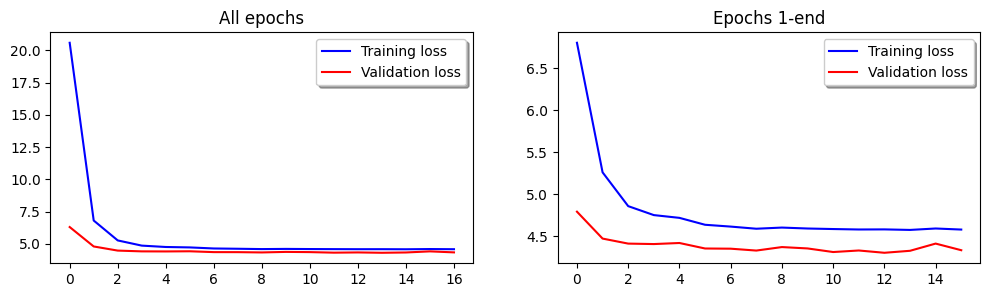

In [11]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()

### Submission
This model got the lowest RMSE

In [16]:
# Prediction

# Interpolate missing values using linear interpolation
Z_interpolated = Z.interpolate(method='linear', axis=1, limit_direction='both')

# Standardize the test data using the same scaler from training
Z2 = Z_interpolated.values

# Reshape for LSTM (same as the training data)
samples, time_steps = Z.shape[0], 72
reshaped_test_data = Z2.reshape(samples, time_steps, -1)

# Standardize
reshaped_test_data = scaler.transform(reshaped_test_data.reshape(-1, reshaped_test_data.shape[-1])).reshape(reshaped_test_data.shape)
print(f"Reshaped test data shape: {reshaped_test_data.shape}")

# Convert to PyTorch tensors
Z_test_tensor = torch.tensor(reshaped_test_data, dtype=torch.float32).to(device)


# Use the trained model to make predictions
model.eval()
with torch.no_grad():
    y_pred = model(Z_test_tensor)  # Get predictions for the test set

# Convert predictions back to CPU for further processing
y_pred_cpu = y_pred.cpu().numpy()

# Create the submission DataFrame
submission['bg+1:00'] = y_pred_cpu.flatten()  # Flatten predictions to match submission format

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Print the submission DataFrame to check
print(submission.head())

Reshaped test data shape: (3644, 72, 1)
         id    bg+1:00
0  p01_8459   9.072382
1  p01_8460   6.405409
2  p01_8461   7.692827
3  p01_8462  10.188564
4  p01_8463   6.936796


## CNN-LSTM Hybrid for Time-Series Forecasting

The **CNN-LSTM hybrid** model combines the strengths of both **Convolutional Neural Networks (CNNs)** and **Long Short-Term Memory (LSTM)** networks for time-series forecasting. CNNs are used to extract spatial features from the input data, while the LSTM network captures the temporal dependencies over time. This hybrid approach is especially useful for time-series data, where both local feature extraction and long-term sequence modeling are crucial for accurate predictions.

### Why CNN-LSTM Hybrid?

- **Convolutional Neural Networks (CNN)**: CNN layer helps extract feature maps from the raw time-series input, which are then passed to the LSTM.
  
  - **Feature Extraction**: The CNN layer acts as a filter, detecting relevant patterns in the data that are likely to improve the prediction accuracy. The **kernel size** of 3 is used for convolution, which is small enough to capture local temporal relationships and avoid overfitting.
  - **ReLU Activation**: The **ReLU** activation function is applied after the convolution operation to introduce non-linearity. This helps the model learn more complex patterns that could not be captured by a linear activation.

- **Long Short-Term Memory (LSTM)**: LSTM networks are designed to learn and remember long-range dependencies in sequences, making them ideal for time-series forecasting tasks. The LSTM in this model receives the output of the CNN layer, which is then processed to capture long-term dependencies.
  
  - **Hidden Size**: The LSTM hidden size is set to 64, which is large enough to capture long-term temporal dependencies in the data while keeping the model computationally efficient.
  - **Dropout for Regularization**: Dropout helps prevent overfitting by randomly setting a fraction of the LSTM's outputs to zero during training, forcing the model to learn more robust representations.
  
- **Fully Connected Layer**: This layer maps the LSTM's output (a sequence of hidden states) to a scalar prediction for blood glucose levels for final output.

### Model Architecture

1. CNN Layer
2. LSTM Layer
3. Dropout Layer
4. Fully Connected (FC) Layer

### Hyperparameters
- CNN Output Channels
- CNN Kernel Size
- LSTM Hidden Size
- LSTM Layers
- Dropout
  
### Training Process

- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam optimizer
- **Early Stopping**: If the validation loss does not improve after a certain number of epochs (patience), training is halted.

In [17]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, output_size, dropout=0.2):
        super(CNNLSTM, self).__init__()
        
        # CNN layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size)
        self.relu = nn.ReLU()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)              # Shape (batch_size, input_size, sequence_length) for Conv1d
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)              # Shape back to (batch_size, sequence_length, cnn_out_channels) for LSTM
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]    # Use last time step
        last_output = self.dropout(last_output)
        output = self.fc(last_output)
        return output

# Model parameters
input_size = reshaped_data.shape[2]         # Features per time step
cnn_out_channels = 32                       # Number of filters in the CNN layer
cnn_kernel_size = 3                         # Kernel size for Conv1d
lstm_hidden_size = 64                       # Hidden size of LSTM layer
lstm_layers = 1                             # Number of LSTM layers
output_size = 1                             # Single output for blood glucose prediction
dropout = 0.2

# Initialize the model, optimizer, and loss function
model = CNNLSTM(input_size, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop with early stopping
num_epochs = 20
patience = 3 
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0         # Keep track of the number of epochs with no improvement
train_losses, val_losses = [], []

# Start time for the entire training process
start_time = time.time()

# Training and validation loop with early stopping
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_cnn_lstm_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_cnn_lstm_model.pth'))

# End time for the entire training process
end_time = time.time()

Epoch 1/20, Training Loss: 5.3464, Validation Loss: 4.2895
Epoch 2/20, Training Loss: 4.4456, Validation Loss: 4.3357
Epoch 3/20, Training Loss: 4.4102, Validation Loss: 4.2325
Epoch 4/20, Training Loss: 4.3607, Validation Loss: 4.2217
Epoch 5/20, Training Loss: 4.3313, Validation Loss: 4.2202
Epoch 6/20, Training Loss: 4.3003, Validation Loss: 4.1932
Epoch 7/20, Training Loss: 4.2641, Validation Loss: 4.1815
Epoch 8/20, Training Loss: 4.2260, Validation Loss: 4.1689
Epoch 9/20, Training Loss: 4.2040, Validation Loss: 4.1658
Epoch 10/20, Training Loss: 4.1963, Validation Loss: 4.1736
Epoch 11/20, Training Loss: 4.1681, Validation Loss: 4.1253
Epoch 12/20, Training Loss: 4.1353, Validation Loss: 4.1417
Epoch 13/20, Training Loss: 4.1278, Validation Loss: 4.1400
Early stopping


In [18]:
# Calculate total training time
training_time = end_time - start_time
print(f"Total Training Time for CNN-LSTM: {training_time:.2f} seconds")

Total Training Time for CNN-LSTM: 698.89 seconds


In [19]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.0314832113343564


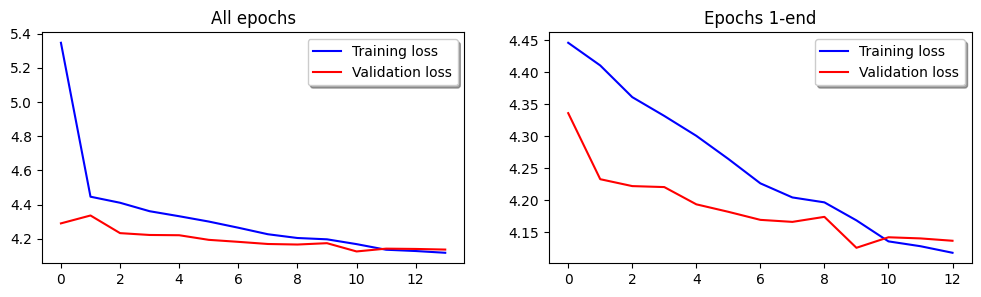

In [20]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()

## Transformer for Time-Series Forecasting

The **Transformer** model leverages self-attention mechanisms to capture long-range dependencies in sequential data. Unlike traditional RNNs, Transformers process the entire sequence in parallel, allowing them to effectively model relationships across time steps.

### Why Transformer?

- **Self-Attention**: The Transformer’s self-attention mechanism allows it to learn dependencies between all time steps in the sequence, capturing both short- and long-range patterns.
  
- **Embedding Dimension**: The model uses an embedding dimension (e.g., 32, 64) to represent each time step, allowing for more complex pattern recognition than a simple scalar input.

- **Parallel Processing**: Transformers process all time steps simultaneously, improving computational efficiency, especially for long sequences.

### Model Architecture

1. Convolutional Layer (for embedding)
2. Transformer Encoder Layer
3. Dropout Layer
4. Fully Connected (FC) Layer

### Hyperparameters
- Embedding Dimension
- Number of Transformer Layers
- Number of Attention Heads
- Dropout Rate
  
### Training Process

- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam optimizer
- **Early Stopping**: Training stops early if validation loss does not improve after a specified number of epochs.

In [21]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_size, embedding_dim, num_heads, hidden_dim, num_layers, output_size, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        
        # Convolutional layer to expand the feature dimension to `embedding_dim`
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=embedding_dim, kernel_size=1)
        
        # Transformer Encoder
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        
        # Fully connected layer for the final output
        self.fc = nn.Linear(embedding_dim, output_size)

    def forward(self, x):
        # Reshape to (batch_size, input_size, sequence_length) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Apply Conv1d for feature embedding
        x = self.conv1d(x)  # Now (batch_size, embedding_dim, sequence_length)
        
        # Reshape for transformer: (sequence_length, batch_size, embedding_dim)
        x = x.permute(2, 0, 1)
        
        # Pass through the Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Reshape back: (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2)
        
        # Use the last time step's output
        x = x[:, -1, :]  # Shape: (batch_size, embedding_dim)
        
        # Final output layer
        output = self.fc(x)  # Shape: (batch_size, output_size)
        
        return output

# Model parameters
input_size = 1                      # Number of initial input features (e.g., 1 for blood glucose)
embedding_dim = 64                  # Embedding dimension for Transformer
num_heads = 2                       # Number of attention heads
hidden_dim = 128                    # Feedforward layer dimension in Transformer
num_layers = 3                      # Number of Transformer encoder layers
output_size = 1                     # Single output for blood glucose prediction
dropout = 0.1

# Initialize the model, optimizer, and loss function
model = TransformerTimeSeries(input_size, embedding_dim, num_heads, hidden_dim, num_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training and validation loop with early stopping
num_epochs = 20
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

# Start time for the entire training process
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_transformer_model.pth'))

# End time for the entire training process
end_time = time.time()

/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Training Loss: 5.0248, Validation Loss: 4.7754
Epoch 2/20, Training Loss: 4.5663, Validation Loss: 4.6083
Epoch 3/20, Training Loss: 4.5178, Validation Loss: 4.5585
Epoch 4/20, Training Loss: 4.4973, Validation Loss: 4.6307
Epoch 5/20, Training Loss: 4.4886, Validation Loss: 4.8229
Early stopping


In [22]:
# Calculate total training time
training_time = end_time - start_time
print(f"Total Training Time for Transformer: {training_time:.2f} seconds")

Total Training Time for Transformer: 1666.49 seconds


In [23]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.135440981346582


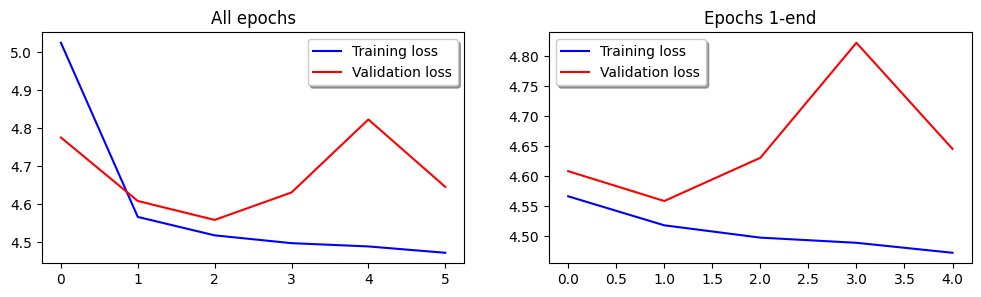

In [24]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()